In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from flytrailvr.utils import extract_data

# generate linear color map from two colors in matplotlib
from matplotlib.colors import LinearSegmentedColormap

pkor = LinearSegmentedColormap.from_list('pkor', ['pink', 'crimson'], N=256)
blnv = LinearSegmentedColormap.from_list('blnv', ['lightskyblue', 'royalblue'], N=256)
    

In [83]:
# data folder
data_folder = '../data/charlie_rig_rishika/'

In [84]:
data = list(filter(lambda x: os.path.isdir(os.path.join(data_folder, x)), os.listdir(data_folder)))
dates = [pd.to_datetime(x.split('_')[-1], format='%Y%m%d-%H%M%S') for x in data]
# sort by date
data = [x for _, x in sorted(zip(dates, data))]
for d in data:
    print(d)

low_wind_wide_20240319-141201
low_wind_thin_20240319-150617
orco_thinstrip_with_odor_20240320-164441
orco_thinstrip_test_20240320-173646
orco_thinstrip_test_20240320-173843
orco_thinstrip_test_20240320-174642
orco_thinstrip_20240321-112203
orco_thinstrip_20240321-112442
orco_thinstrip_low_wind_20240321-114717
orco_thinstrip__no_wind_visual_20240321-121715
orco_thinstrip_low_wind_20240321-150513
orco_thinstrip_low_wind_20240321-151534
orco_alternated_wind_20240321-153548
orco_alternated_wind_48hr_20240322-105843
orco_thinstrip_lowwind_20240322-114228


In [91]:

sample_data = 'orco_alternated_wind_48hr_20240322-105843'

In [92]:
df, config, logic, comments = extract_data(os.path.join(data_folder, sample_data))

/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:32: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [93]:
def process_important_variables(df, config):
    """
    Process important variables from the data file
    
    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe containing the data
    config : dict
        Dictionary containing the config information
        
    Returns
    -------
    var_dict : dict
        Dictionary containing the important variables:
        - t : time
        - x : x position
        - y : y position
        - heading : heading
        - odor : odor
        - flowrate : flowrate
        - led : led
        - strip_width : strip width
        - periodic_boundary : periodic boundary
        - period_width : period width
    """
    t = (df['timestamp']-df['timestamp'].iloc[0]).dt.total_seconds()
    pre_duration = float(config['pre_onset_time'])
    t0 = t[t > pre_duration].iloc[0]
    x0 = df['ft_posx'][t > pre_duration].iloc[0]
    y0 = df['ft_posy'][t > pre_duration].iloc[0]

    x = (df['ft_posx']-x0) / 1000
    y = (df['ft_posy']-y0) / 1000
    t = t-t0
    heading = df['ft_heading']*180/np.pi

    flowrate = df['mfc2_stpt'].values + df['mfc1_stpt'].values

    odor = df['mfc2_stpt'].values
    odor = (odor - odor.min()) / (odor.max() - odor.min())

    led = 1-df['led1_stpt'].values

    # create a dictionary of the variables
    var_dict = {
        't': t,
        'x': x,
        'y': y,
        'heading': heading,
        'odor': odor,
        'flowrate': flowrate,
        'led': led,
    }

    return var_dict

In [102]:
def plot_trajectory(
        df,
        config,
        scale_factor=1,
        show=True,
        save=None,
        colormaps=[pkor],
        odor_or_led='odor'
):
    # process the important variables
    processed_data = process_important_variables(df, config)
    t = processed_data['t']
    x = processed_data['x']
    y = processed_data['y']
    odor = processed_data['odor']
    led = processed_data['led']
    colorvar = odor if odor_or_led == 'odor' else led
    flowrate = processed_data['flowrate']

    unique_flow_rates = np.unique(flowrate)
    # sort the unique flow rates
    unique_flow_rates = np.sort(unique_flow_rates)
    assert unique_flow_rates.size == len(colormaps), 'Number of colormaps should be equal to the number of unique flowrates'

    # set the figure size
    xby = (x.max()-x.min())/(y.max()-y.min())
    fig, ax = plt.subplots(figsize=(xby*scale_factor+1, 1*scale_factor))
    
    # plot the trajectory (different colors for different flow rates)
    for i, flow_rate in enumerate(unique_flow_rates):
        idx = flowrate == flow_rate
        ax.scatter(x[idx], y[idx], c=colorvar[idx], cmap=colormaps[i], s=0.5)
        print(f'Flow rate: {flow_rate}, color: {str(colormaps[i])}')


    # mark the start
    ax.plot(x[0], y[0], '*', color='black', markersize=10)
    ax.text(x[0], y[0], '  start', fontsize=10, color='black')


    # add the odor lines
    if config['periodic_boundary']:
        period_width = config['period_width']/1000
        strip_width = config['strip_width']/1000
        max_x = int(x.max()//period_width)
        min_x = int(x.min()//period_width)
        for i in range(min_x, max_x+1, 1):
            start_x = i*period_width-strip_width/2
            end_x = i*period_width+strip_width/2
            ax.fill_betweenx([y.min(), y.max()], start_x, end_x, color='grey', alpha=0.2)
    else:
        strip_width = config['strip_width']/1000
        ax.fill_betweenx([y.min(), y.max()], -strip_width/2, strip_width/2, color='grey', alpha=0.2)
        
    # set axis properties
    ax.set_aspect('equal')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.tight_layout()


    if save is not None:
        plt.savefig(save, dpi=300)

    if show:
        plt.show()
    else:
        plt.close()


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_50612/1886864349.py:41: RuntimeWarning: invalid value encountered in divide
  odor = (odor - odor.min()) / (odor.max() - odor.min())


Flow rate: 0.02, color: <matplotlib.colors.LinearSegmentedColormap object at 0x7f9e3ba5e910>
Flow rate: 0.3, color: <matplotlib.colors.LinearSegmentedColormap object at 0x7f9e3bab44c0>


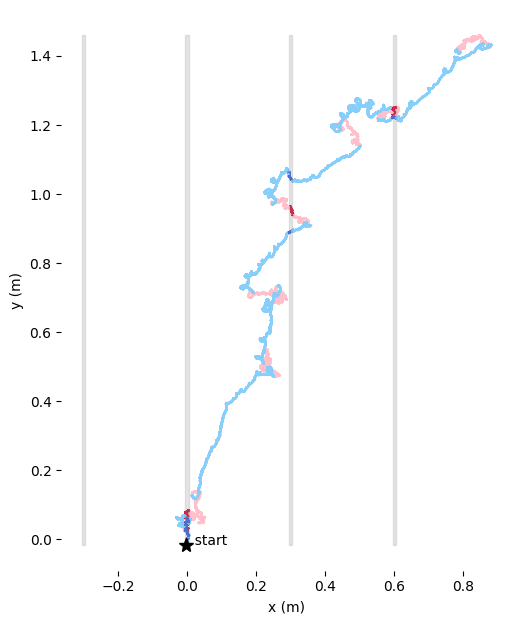

In [103]:
plot_trajectory(df, config, scale_factor=7, show=True, save=None, colormaps=[pkor, blnv], odor_or_led='led')

In [90]:
config

{'instant_replay': False,
 'include_pre_air': True,
 'log_dir': '/home/rutalab/Desktop/log_files/',
 'strip_angle': 0,
 'strip_direction': 'right',
 'strip_width': 10,
 'periodic_boundary': True,
 'period_width': 100,
 'flowrate': 300,
 'flowrate_high': 300,
 'flowrate_low': 20,
 'alternation_time': 120,
 'percent_odor': 20,
 'pre_onset_time': 120,
 'led_intensity': 100,
 'led_color': 'red',
 'window_len': 120,
 'pulse_period': 10.0}

In [31]:
speedup_factor = 100
frame_rate = 60

duration = t.max()-t.min()
run_time = duration/speedup_factor
n_frames = int(run_time*frame_rate)
time_between_frames = duration/n_frames

times_to_show = np.arange(t.min(), t.max(), time_between_frames)
# find the nearest time to the times to show
frames = []
for time in times_to_show:
    frame = np.argmin(np.abs(t-time))
    frames.append(frame)

In [33]:
duration/60


25.677659116666668

Frames:   0%|          | 0/924 [00:00<?, ?it/s]

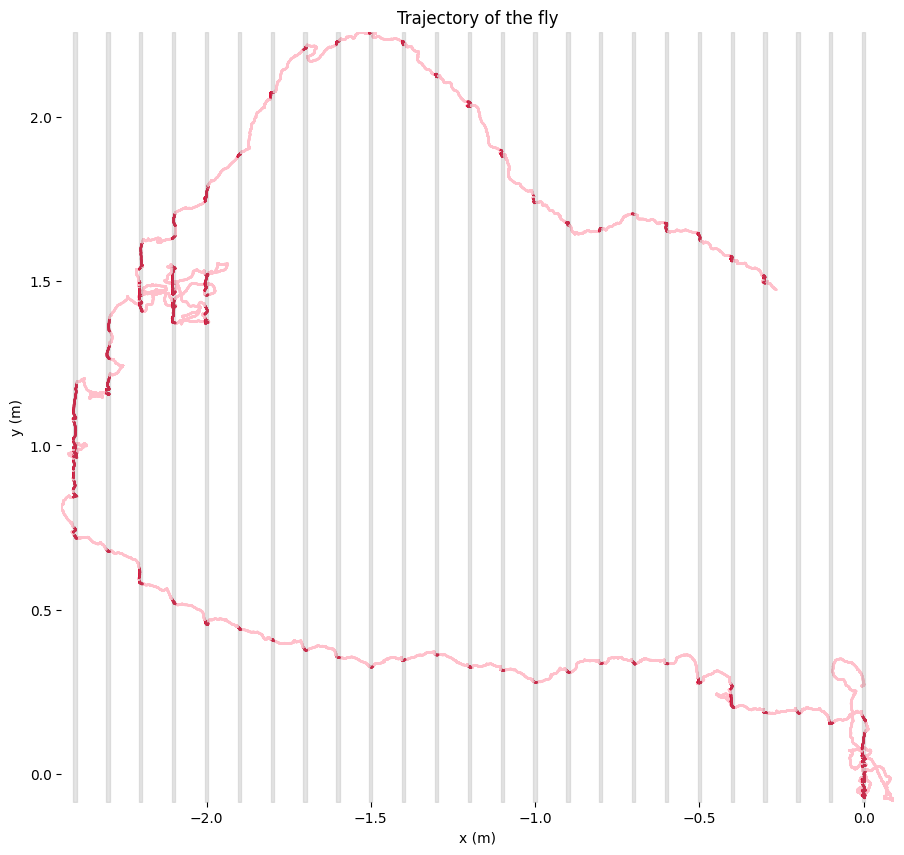

In [35]:
# convert to a mp4 animation
import matplotlib.animation as animation
from tqdm.notebook import tqdm

fig, ax = plt.subplots(figsize=(xby*scale_factor+1, scale_factor))
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Trajectory of the fly')
ax.set_aspect('equal')
# remove the box
for spine in ax.spines.values():
    spine.set_visible(False)

sc = ax.scatter([], [], c=[], cmap=pkor, s=0.5)
# add the odor lines
max_x = int(x.max()//period_width)
min_x = int(x.min()//period_width)
for i in range(min_x, max_x+1, 1):
    start_x = i*period_width-strip_width/2
    end_x = i*period_width+strip_width/2
    ax.fill_betweenx([y.min(), y.max()], start_x, end_x, color='grey', alpha=0.2)

def update(frame):
    sc.set_offsets(np.c_[x[:frame], y[:frame]])
    # set the color
    sc.set_color(pkor(odor[:frame]))
    return sc,

ani = animation.FuncAnimation(fig, update, frames=tqdm(frames, desc='Frames'), blit=True)
ani.save(f'figures/{sample_data}_trajectory.mp4', fps=frame_rate, dpi=300)
